In [304]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [305]:
from scipy import optimize
import math as math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

# A simple CGE model
In the first section of this code we construct a simple Computable General Equilibruim (CGE) model and calibrate it to an observed equilibrium. In the second section of this code we examine the properties of the model and the effect of certain shocks.

## Building a CGE model - a crash course in CGE-modelling
The building blocks of a CGE model are:
1. Model equations describing an economy
2. Behavioural parameters
3. Variable values representing an initial equilibrium

Below we will construct a simple CGE model in three steps:
1. We will define the model's equations. The model is a simple open economy with producers, consumers and a world market
2. We will discuss the behavioural parameters
3. We will calibrate the models unknown behavioural parameters such that the model can replicate the initial equilibrium

### 1. Model equations
Our model is a slightly modified version of a model from the course in applied CGE-modelling. The model consists of producers who buy labour and produce a single domestic consumption good, cosumers who sell labour to domestic producers and buy both domestic and foregin consumption goods, and a world market where producers can sell sell domestic goods and consumers can buy foreign goods.
#### Domestic producers
The domestic producers are in full competition with each other and all have the CES-production function:

$$ Y = \left[ \mu^\frac{1}{E_Y} L^\frac{E_Y-1}{E_Y} \right]^\frac{E_Y}{E_Y-1} $$

They maximize their profits:

$$ \pi = p_dY - wL $$

This implies the following labour demand and zero profit condition, i.e. the price of the domestic consumption good is equal to the avg. costs of producing it.

$$ 
\begin{align}
L = \mu  \left( \frac{w}{p_d} \right)^{-E_Y} Y \tag{1}
\end{align}
$$

$$ 
\begin{align}
p_d = \frac{w L}{Y} \tag{2} 
\end{align}
$$

Below we define the two equations:

In [306]:
## Labour demand
def E1_L_D(mu,w,p_d,E_Y,Y) :
    """ Funtion defining the producers' demand for labour. """
    return mu * (w/p_d)**(-E_Y) * Y

## Zero profit condition - expressed as a function of p_d
def E2_p_d(Y,w,L) :
    """  Function defining the zero profit condidtion. """
    return w*L / Y

#### Domestic consumers
The model has N domestic consumers who have a CES utility function and derive utility from the consumption of domestic and foreign goods:

$$ U(C_d,C_f)=\left[ \gamma_d^\frac{1}{E_C} C_d^\frac{E_C-1}{E_C} + \gamma_f^\frac{1}{E_C} C_f^\frac{E_C-1}{E_C} \right]^\frac{E_C}{E_C-1} $$

Their budget constaint is:

$$
\begin{align}
p_d C_d + p_f C_f = w N \tag{3}
\end{align}
$$

The consumers maximize their utility subject to their budget constraint. This implies the following demand functions:

$$
\begin{align}
C_d = \gamma_d \left(\frac{p_d}{P_C}\right)^{-E_C} \frac{wN}{P_C} \tag{4}
\end{align}
$$

$$
\begin{align}
C_f = \gamma_d \left(\frac{p_f}{P_C}\right)^{-E_C} \frac{wN}{P_C} \tag{5}
\end{align}
$$

$P_C$ is a CES-price index.

In [307]:
## The budget of the households constraint
def E3_wN(p_d,C_d,p_f,C_f) :
    """ Budget constraint of the households. """
    return p_d*C_d+p_f*C_f

## The demand for the domestic consumption good
def E4_C_d(gamma_d,p_d,P_C,E_C,w,N) :
    """ Demand for domestic consumption."""
    return gamma_d * (p_d/P_C)**(-E_C) *w*N/P_C

## The demand for the foreign consumption good
def E5_C_f(gamma_f,p_f,P_C,E_C,w,N) :
    """ Demand for foregin consumption good."""
    return gamma_f * (p_f/P_C)**(-E_C) *w*N/P_C

#### The labour market
We assume that everybody works. Thus the labour market becomes:

$$
\begin{align}
L = N \tag{6}
\end{align}
$$

In [308]:
## The labour market
def E6_L_S(N) :
    """ Labour market. """
    return N

#### The goods market
In equilibria the entire domestic production is either consumed by domestic consumers or exported:

$$ 
\begin{align}
Y = C_d + X \tag{7}
\end{align}$$

In [309]:
## The goods market
def E7_Y(C_d,X) :
    """ The goods market. """
    return C_d + X

#### Foregin trade
We model the foreign trade using an Armington's approach, where the export depends on the relative price of foreign and domestic goods:

$$ 
\begin{align}
X = \phi \left(\frac{p_d}{p_f}\right)^{-E_X} \tag{8}
\end{align}
$$

We use the foreign price as a numéraire:

$$
\begin{align}
p_f = 1 \tag{9}
\end{align}
$$

In [310]:
## Armington's approach to foreign trade
def E8_X(phi,p_d,p_f,E_X) :
    """ Foreign trade """
    return phi*(p_d/p_f)**(-E_X)

## Setting the foreign price as a numéraire
def E9_p_f() :
    """ The price of the foreign good """
    return 1

#### The model
Equation (1)-(9) represents the nine equations in our model. We treat the nine variables $Y$, $L$, $w$, $C_d$, $C_f$, $p_d$, $p_f$, $P_C$, and $X$ as endogenous.

The remaining parameters are $N$, $\mu$, $\gamma_d$, $\gamma_f$, $\phi$, $E_Y$, $E_C$ and $E_X$.

### 2. Behavioural parameters
The model has 8 unknown parameters: $N$, $\mu$, $\gamma_d$, $\gamma_f$, $\phi$, $E_Y$, $E_C$ and $E_X$. $\mu$, $\gamma_d$, $\gamma_f$, $\phi$, $E_Y$, $E_C$ and $E_X$ are the so-called behavioural parameters in the CES-functions and in Armington's approach to foreign trade. In the original assignment from the course in applied CGE-modelling, it was given that $E_Y \equiv 2.0$, $E_C \equiv 0.5$, and $E_C \equiv 5.0$.

The remaining behavioural parameters and $N$ are determined by calibrating the model to the initial equilibrium, e.g. setting $\phi$ in equation $(8)$ such that the equation is consistent with the initial values of $X$, $p_d$, and $p_f$.

In [311]:
E_Y = 2.0
E_C = 0.5
E_X = 5.0

### 3. Initial dataset and calibration
To model is calibrated to an initial equilibrium described by the IO-table:

| I/O | $PS$   | $PC$  | $X$   |
| --- | --:  | --: | --: |
| $PS$  | 0    | 800 | 200 |
| $M$   | 0    | 200 |   0 |
| $w$ | 1000 | 0   |   0 |

PS is the private sector, $M$ is imports, $w$ is wages, PC is private consumption, and $X$ is exports. The rows describe input and the columns output. The private sector e.g. uses 1.000 units of wage, and outputs 800 units of goods used for domestic consumption. The table represents a simple National Account in current prices.

In [312]:
rows    = ['PS','M' ,'w']
columns = ['PS','PC','X']

data = [(0    , 800 , 200),
        (0    , 200 ,   0) ,
        (1000 , 0   ,   0) ]

IO = pd.DataFrame(data,columns=columns,index=rows)

#### Initialising the variables
All prices are simply set to 1 and interpretated as price indices. The ammount of labour, the total prodcution etc. are found using the IO-table. The IO-table is in current prices so we devide by the price indices.

In [313]:
## Endogenous variables in initial equilibrium
# Prices
p_d0 = 1
p_f0 = 1
w0   = 1
P_C0 = 1

# Amounts
L0   = IO.loc['w']['PS']/w0
Y0   = IO.loc['w']['PS']/p_d0
X0   = IO.loc['PS']['X']/p_d0
C_d0 = IO.loc['PS']['PC']/p_d0
C_f0 = IO.loc['M']['PC']/p_f0

## List of initial values
ini_list = [Y0,L0,w0,C_d0,C_f0,p_d0,p_f0,P_C0,X0]

We also save the initial equilibrium in a dataframe.

In [314]:
## Saving initial equilibrium in a dictionary
ini_eq = [{"Shock" : "Initial eq.", 
            "$L$"   : "%1.f"  % L0,
            "$Y$"   : "%0.2f" % Y0,
            "$w$"   : "%0.3f" % w0,
            "$C_d$" : "%0.2f" % C_d0,
            "$p_d$" : "%0.3f" % p_d0,
            "$C_f$" : "%0.2f" % C_f0,
            "$p_f$" : "%0.3f" % p_f0,
            "$P_C$" : "%0.3f" % P_C0,
            "$X$"   : "%0.2f" % X0}]

## Converting the dictionary to a data-frame
ini_eq = pd.DataFrame(ini_eq)

## Rearranging the columns of the dataframe
cols = ['Shock','$L$','$Y$','$X$','$C_d$','$C_f$','$w$','$p_d$','$p_f$','$P_C$']
ini_eq = ini_eq[cols]

## Printing the inital equilibrium
ini_eq

,Shock,$L$,$Y$,$X$,$C_d$,$C_f$,$w$,$p_d$,$p_f$,$P_C$
0,Initial eq.,1000,1000.00,200.00,800.00,200.00,1.000,1.000,1.000,1.000


#### Calibrating
The next step is to calibrate $N$, $\mu$, $\gamma_d$, $\gamma_f$, $\phi$, i.e. setting their values such that the model replicates the initial equilibrium. In the case of e.g. $\mu$ this is done by solving the labour demand function, equation (1), for $\mu$ with the inital values inserted:

$$ 
\begin{align}
L_0 = \mu  \left( \frac{w_0}{p_{d0}} \right)^{-E_Y} Y_0
\end{align}
$$

We do this numerically below.

In [315]:
## Calibrating population size
def f_L_S(N) :
    return E6_L_S(N) - L0

solution = optimize.root(f_L_S, (0) )
N = np.asscalar(solution.x)

## Calibrating mu
def f_mu(mu) :
    return E1_L_D(mu,w0,p_d0,E_Y,Y0) - L0

solution = optimize.root(f_mu, (0) )
mu = np.asscalar(solution.x)

## Calibrating gamma_d and gamma_f
def f_gamma_d(gamma_d) :
    return E4_C_d(gamma_d,p_d0,P_C0,E_C,w0,N) -C_d0

solution = optimize.root(f_gamma_d, (0) )
gamma_d = np.asscalar(solution.x)

def f_gamma_f(gamma_f) :
    return E5_C_f(gamma_f,p_f0,P_C0,E_C,w0,N) -C_f0

solution = optimize.root(f_gamma_f, (0) )
gamma_f = np.asscalar(solution.x)

## Calibrating phi
def f_phi(phi) :
    return E8_X(phi,p_d0,p_f0,E_X) - X0

solution = optimize.root(f_phi, (0) )
phi = np.asscalar(solution.x)

## Printing the results
print("N =",N,", mu =",mu,",","gamma_d =",gamma_d,",","gamma_f =",gamma_f,",","phi =",phi)

N = 1000.0 , mu = 1.0 , gamma_d = 0.8 , gamma_f = 0.2 , phi = 200.0


#### Solving the model
The last step of building our model is to solve it and check if it replicates the initial equilibrium. If it does then our model works. This is called a zero-shock in CGE-modelling.

In [316]:
## Function solving the CGE model taking parameters as inputs
def CGEsolve(N,mu,gamma_d,gamma_f,phi,E_Y,E_C,E_X,ini_list,status='yes') :
    """
    This function defines and solves the CGE-model as a function of its parameters and
    a list of inital values for the solver.
    
    status = 'yes' prints a summary of the solver results
    """
    ## Defining the CGE model as a system of nine equations and nine unknowns
    def CGEmodel(variables) :
        ## Defining variables
        (Y,L,w,C_d,C_f,p_d,p_f,P_C,X) = variables

        ## Defining equations
        EQ_L_D = E1_L_D(mu,w,p_d,E_Y,Y) - L
        EQ_p_d = E2_p_d(Y,w,L) - p_d
        EQ_wN  = E3_wN(p_d,C_d,p_f,C_f) - w*N
        EQ_C_d = E4_C_d(gamma_d,p_d,P_C,E_C,w,N) - C_d
        EQ_C_f = E5_C_f(gamma_f,p_f,P_C,E_C,w,N) - C_f
        EQ_L_S = E6_L_S(N) - L
        EQ_Y   = E7_Y(C_d,X) - Y
        EQ_X   = E8_X(phi,p_d,p_f,E_X) - X
        EQ_p_f = E9_p_f()-p_f
        
        ## Returning a list of equations
        return [EQ_L_D,EQ_p_d,EQ_wN,EQ_C_d,EQ_C_f,EQ_L_S,EQ_Y,EQ_X,EQ_p_f]
   
    ## Solving the model 
    solution = optimize.root(CGEmodel,(ini_list[0],ini_list[1],ini_list[2],ini_list[3],ini_list[4],ini_list[5],ini_list[6],ini_list[7],ini_list[8]))
    if status=='yes' :
        print(solution.message,"Success =",solution.success)
    
    ## Returning solution
    return solution

## Solving the model
zeroshock = CGEsolve(N,mu,gamma_d,gamma_f,phi,E_Y,E_C,E_X,ini_list,status='yes')

The solution converged. Success = True


In [317]:
## Function creating a dataframe with results
def CGEresults(solution,name) :
    """
    This function takes the results from CGEsolve function and stores the variable values in a data frame.
    
    solution = a result from the CGEsolve function
    name = name of the shock
    """
    ## Saving the results in a dictionary
    results = [{"Shock" : name, 
                "$Y$"   : "%0.2f" % solution.x[0],
                "$L$"   : "%1.f"  % solution.x[1],
                "$w$"   : "%0.3f" % solution.x[2],
                "$C_d$" : "%0.2f" % solution.x[3],
                "$p_d$" : "%0.3f" % solution.x[5],
                "$C_f$" : "%0.2f" % solution.x[4],
                "$p_f$" : "%0.3f" % solution.x[6],
                "$P_C$" : "%0.3f" % solution.x[7],
                "$X$"   : "%0.2f" % solution.x[8]}]
    
    ## Converting the results to a dataframe
    results = pd.DataFrame(results)
    
    ## Rearranging the columns
    cols = ['Shock','$L$','$Y$','$X$','$C_d$','$C_f$','$w$','$p_d$','$p_f$','$P_C$']
    results = results[cols]
    
    ## Returning the dataframe
    return results

## Printing the results
ini_eq.append(CGEresults(zeroshock,'Zero-shock'))

,Shock,$L$,$Y$,$X$,$C_d$,$C_f$,$w$,$p_d$,$p_f$,$P_C$
0,Initial eq.,1000,1000.00,200.00,800.00,200.00,1.000,1.000,1.000,1.000
0,Zero-shock,1000,1000.00,200.00,800.00,200.00,1.000,1.000,1.000,1.000


We have successfully solved the model. Our 'zero'-shock replicates the intial equilibrium. The model is correctly calibrated.

## The effect of a productivity shock

In [318]:
prodshock = CGEsolve(N,1.1*mu,gamma_d,gamma_f,phi,E_Y,E_C,E_X,ini_list,status='yes')

The solution converged. Success = True


In [319]:
ini_eq.append(CGEresults(prodshock,'Prod-shock'))

,Shock,$L$,$Y$,$X$,$C_d$,$C_f$,$w$,$p_d$,$p_f$,$P_C$
0,Initial eq.,1000,1000.00,200.00,800.00,200.00,1.000,1.000,1.000,1.000
0,Prod-shock,1000,1100.00,221.83,878.17,217.28,1.077,0.979,1.000,0.984


How does the effect of the shock depend on $E_X$?

In [320]:
shock = CGEsolve(N,1.1*mu,gamma_d,gamma_f,phi,E_Y,E_C,1,ini_list,status='yes')
results = CGEresults(shock,1)

The solution converged. Success = True


In [321]:
for i in range(11,301) :
    #print(0.1*i)
    shock = CGEsolve(N,1.1*mu,gamma_d,gamma_f,phi,E_Y,E_C,0.1*i,ini_list,status='no')
    results = results.append(CGEresults(shock,0.1*i))

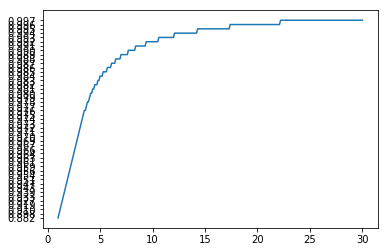

In [322]:
plt.plot(results['Shock'],results['$P_C$'])
plt.show()